# AIM: develop the pretext task with EEGNet

In [1]:
import numpy as np
import pandas as pd
import mne
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import F1Score
import random
import os
import matplotlib.pyplot as plt

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

In [2]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }


## Create montage
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')

# Create info object for MNE
info = mne.create_info(ch_names=ch_names[:32], ch_types=ch_types[:32], sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>


## EEGNet:

In [3]:
# create Conv2d with max norm constraint
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm: int = 1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)

In [4]:
from typing import Sequence


from lightning.pytorch.callbacks.callback import Callback


class EEGNet(pl.LightningModule):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self,
                 chunk_size: int = 9950, # number of data points in each EEG chunk
                 num_electrodes: int = 26, # number of EEG electrodes
                 F1: int = 8, # number of filters in first convolutional layer
                 F2: int = 16, # number of filters in second convolutional layer
                 D: int = 2, # depth multiplier
                 num_classes: int = 2, # number of classes to predict
                 kernel_1: int = 250, # the filter size of block 1 (half of sfreq (500 Hz))
                 kernel_2: int = 63, # the filter size of block 2 (one eight of sfreq (500 Hz))
                 dropout: float = 0.25): # dropout rate
        super(EEGNet, self).__init__()
        self.F1 = F1
        self.F2 = F2
        self.D = D
        self.chunk_size = chunk_size
        self.num_classes = num_classes
        self.num_electrodes = num_electrodes
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.dropout = dropout

        self.block1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
            nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
            Conv2dWithConstraint(self.F1,
                                 self.F1 * self.D, (self.num_electrodes, 1),
                                 max_norm=1,
                                 stride=1,
                                 padding=(0, 0),
                                 groups=self.F1,
                                 bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

        self.block2 = nn.Sequential(
            nn.Conv2d(self.F1 * self.D,
                      self.F1 * self.D, (1, self.kernel_2),
                      stride=1,
                      padding=(0, self.kernel_2 // 2),
                      bias=False,
                      groups=self.F1 * self.D),
            nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
            nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
            nn.Dropout(p=dropout))

        self.lin = nn.Linear(self.feature_dim(), num_classes, bias=False)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

    def feature_dim(self):
        # function to calculate the number of features after the convolutional blocks
        with torch.no_grad():
            mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

            mock_eeg = self.block1(mock_eeg)
            mock_eeg = self.block2(mock_eeg)

        return self.F2 * mock_eeg.shape[3]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = x.flatten(start_dim=1)
        x = self.lin(x)
        return x
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.unsqueeze(1)
        x = x.float()
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        y_hat = F.log_softmax(logits, dim=1)
        y_hat = y_hat.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.unsqueeze(1)
        x = x.float()
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        y_hat = F.log_softmax(logits, dim=1)
        y_hat = y_hat.argmax(dim=1)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        x = x.unsqueeze(1)
        x = x.float()
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        y_hat = F.log_softmax(logits, dim=1)
        y_hat = y_hat.argmax(dim=1)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
        return loss
    
    def predict_step(self, batch):
        x = batch
        x = x.unsqueeze(1)
        x = x.float()
        logits = self.forward(x)
        y_hat = F.log_softmax(logits, dim=1)
        y_hat = y_hat.argmax(dim=1)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    


## Pretext task

In [5]:
# function to get list with all filepaths of EEG data
# def get_filepaths(eeg_dir, sample_ids, recording_condition):
#     """
#     Function to get all filepaths of EEG data for a specific recording condition and sample_ids
#     :param eeg_dir: directory where EEG data is stored
#     :param sample_ids: list of sample_ids to include
#     :param recording_condition: recording condition to include (EC or EO) (str)
#     :return: list of filepaths
#     """
#     filepaths = []
#     for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
#         for file in files:
#             if any(sample_id in file for sample_id in sample_ids): # filter participants to include
#                 if recording_condition in file and 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
#                     filepath = os.path.join(subdir, file) # path to eeg file
#                     filepaths.append(filepath)
#     return filepaths

def get_filepaths(eeg_dir, sample_ids, recording_condition):
    """
    Function to get all filepaths of EEG data for a specific recording condition and sample_ids
    :param eeg_dir: directory where EEG data is stored
    :param sample_ids: list of sample_ids to include
    :param recording_condition: recording condition to include (EC or EO) (str)
    :return: list of filepaths
    """
    filepaths = []
    for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
        for file in files:
            if any(sample_id in file for sample_id in sample_ids): # filter participants to include
                if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                    filepath = os.path.join(subdir, file) # path to eeg file
                    filepaths.append(filepath)
    return filepaths

def get_participant_ids(eeg_dir):
    """
    Function to get all participant ids for a specific recording condition
    :param eeg_dir: directory where EEG data is stored
    :return: list of participant ids
    """
    participant_ids = []
    for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
        for file in files:
            if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                participant_id = file.split('_')[0] # extract participant id
                if participant_id not in participant_ids:
                    participant_ids.append(participant_id)
    return participant_ids


# function to load and epoch EEG data
def load_and_epoch_data(filepath):

    # load data
    eeg_data = np.load(filepath, allow_pickle=True)
    eeg_data = mne.io.RawArray(np.squeeze(eeg_data['data']), info)

    # epoch data
    epochs = mne.make_fixed_length_epochs(eeg_data, duration=9.95, overlap=0, preload=True)
    epochs = epochs.pick_types(eeg=True) # only select EEG channels
    epochs = epochs.get_data(copy=False) # convert to array

    return epochs

# function to sample two epochs and assign a label depending on whether the epochs are adjacent or not
def sample_two_epochs(epochs):
    if random.random() > 0.5: # decide whether to sample two adjacent epochs or two seperated epochs
        label = 1
        sample_idx = random.randint(0, len(epochs)-2) # -2 to prevent sampling the last epoch
        sample_idxs = [sample_idx, sample_idx+1]
    else:
        label = 0
        sample_idx = random.randint(0, len(epochs)-1)
        sample_idxs = [sample_idx, random.choice([i for i in range(len(epochs)) if i not in [sample_idx - 1, sample_idx, sample_idx + 1]])] 
    sampled_epochs = epochs[sample_idxs]
    sampled_epochs = sampled_epochs.reshape(26, 9950)
    # print(sample_idxs, label)    
    return sampled_epochs, label

In [6]:
# function to create a dataset with EEG data
## CREATED WITH HELP OF GITHUB COPILOT
class RPDataset(torch.utils.data.Dataset):
    def __init__(self, eeg_dir, sample_ids, recording_condition):
        self.filepaths = get_filepaths(eeg_dir, sample_ids, recording_condition)
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        epochs = load_and_epoch_data(self.filepaths[idx])
        sampled_epochs, label = sample_two_epochs(epochs)
        return sampled_epochs, label

In [7]:
# create dataset
from torch.utils.data import DataLoader
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\preprocessed"
participant_ids = get_participant_ids(eeg_dir)
sample_ids = random.sample(participant_ids, 100) # randomly select 100 participants for testing

dataset = RPDataset(eeg_dir, participant_ids, 'EC')
print(len(dataset))
print(dataset[0][0].shape)      

2500
(26, 9950)


In [8]:
# obtain indices of dataset split into train, validation, and test set
# code from github copilot
from sklearn.model_selection import train_test_split

labels = np.array([sample[1] for sample in dataset])
data_trainval_indices, data_test_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=labels
)
trainval_labels = labels[data_trainval_indices]
data_train_indices, data_val_indices = train_test_split(
    data_trainval_indices, test_size=0.2, random_state=42, stratify=trainval_labels
)

# Save indices to disk
np.save('data_train_indices.npy', data_train_indices)
np.save('data_val_indices.npy', data_val_indices)
np.save('data_test_indices.npy', data_test_indices)

In [9]:
# obtain actual train, val, test splits
# code from github copilot
from torch.utils.data import Subset

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')
data_test_indices = np.load('data_test_indices.npy')

# Create subsets using the indices
data_train = Subset(dataset, data_train_indices)
data_val = Subset(dataset, data_val_indices)
data_test = Subset(dataset, data_test_indices)

# Print dataset sizes and label distributions
train_labels = [dataset[i][1] for i in data_train_indices]
val_labels = [dataset[i][1] for i in data_val_indices]
test_labels = [dataset[i][1] for i in data_test_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(data_test)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_labels, return_counts=True)}")

Train: 1600, Val: 400, Test: 500
Train: (array([0, 1]), array([800, 800], dtype=int64))
Val: (array([0, 1]), array([201, 199], dtype=int64))
Test: (array([0, 1]), array([255, 245], dtype=int64))


In [10]:
# train model
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="pretext_task")

# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

model = EEGNet()
trainer = Trainer(
    precision='16-mixed',
    accelerator='gpu',
    devices=1,
    max_epochs=10,
    callbacks=checkpoint_callback,
    enable_progress_bar=True,
    enable_model_summary=True,
    enable_checkpointing=True,
    logger=logger,
    log_every_n_steps=5,
)

train_loader = DataLoader(data_train, batch_size=100, shuffle=True, drop_last=True)
val_loader = DataLoader(data_val, batch_size=len(data_val), shuffle=False, drop_last=True)

trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | block1   | Sequential        | 2.5 K 
1 | block2   | Sequential        | 1.3 K 
2 | lin      | Linear            | 9.9 K 
3 | train_f1 | MulticlassF1Score | 0     
4 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
13.7 K    Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## plotting model diagnostics

In [11]:
# load metrics data
metrics = pd.read_csv(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\logs\pretext_task\version_0\metrics.csv')
train_f1_epoch = metrics['train_f1_epoch'].dropna()
train_loss_epoch = metrics['train_loss_epoch'].dropna()
val_f1 = metrics['val_f1'].dropna()
val_loss = metrics['val_loss'].dropna()
print(len(train_f1_epoch), len(train_loss_epoch), len(val_f1), len(val_loss))

10 10 10 10


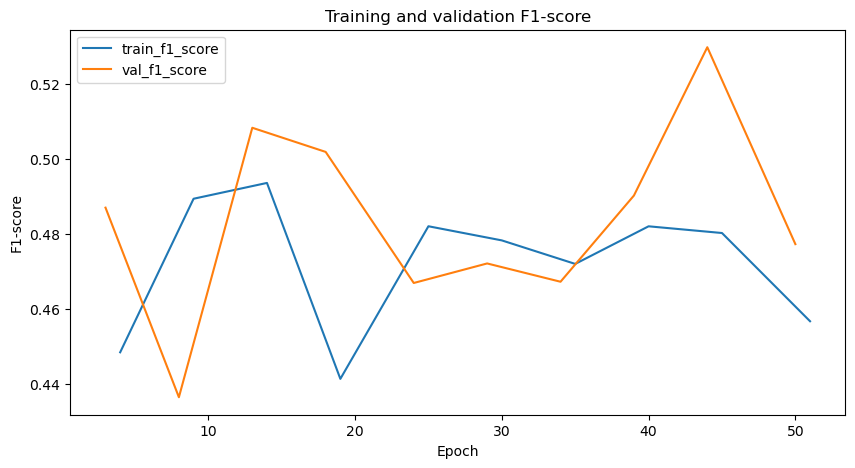

In [12]:
# plot training and validation f1-score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_epoch, label='train_f1_score')
plt.plot(val_f1, label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.title('Training and validation F1-score')
plt.show()


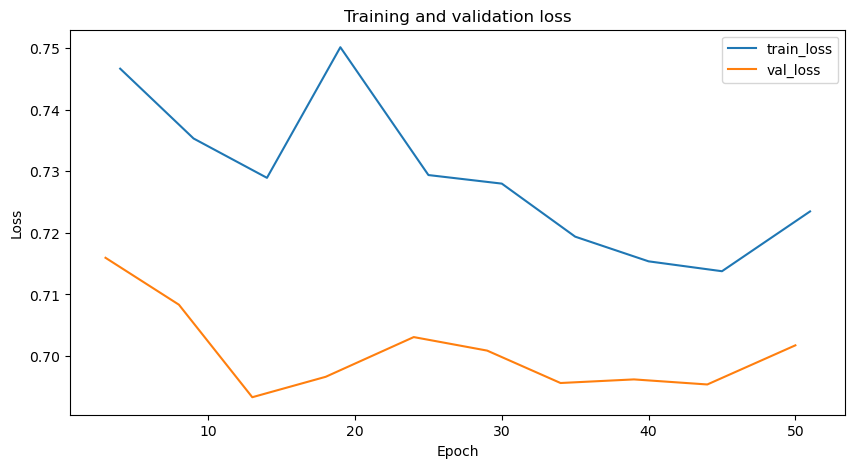

In [13]:
# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()